In [173]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import debug
from sklearn.cluster import KMeans


In [174]:
SIZE = 700

In [175]:
# Configure image
image = cv2.imread("../images/boards/yellow_black_up.jpeg")
image_size = (SIZE,SIZE)
image = cv2.resize(image,image_size)


In [176]:
def _detect_edges(image: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if gray.dtype != np.uint8:
        gray = gray / gray.max() * 255
        gray = gray.astype(np.uint8)
    edges = cv2.Canny(gray, 90, 400, 3)
    return edges

canny = _detect_edges(image)

Detect chessboard borders

In [220]:

def _generate_edges_lines(canny: np.ndarray) -> np.ndarray:
    
    lines = cv2.HoughLines(canny,rho = 1, theta = np.pi / 180, threshold = 100)
    
    lines = lines.reshape(len(lines),2)
        
    origin_lines = lines[lines[:, 1].argsort()]
    
    coor_lines = []
    for line in origin_lines:
        rho,theta = line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 +1000*(-b))
        y1 = int(y0 +1000*(a))
        x2 = int(x0 -1000*(-b))
        y2 = int(y0 -1000*(a))   
        coor_lines.append(((x1,y1),(x2,y2)))
    
    return np.array(coor_lines)
    
lines = _generate_edges_lines(canny)

print(lines)

[[[  670  1000]
  [  670 -1000]]

 [[  524  1000]
  [  524 -1000]]

 [[  587  1000]
  [  587 -1000]]

 [[  597  1000]
  [  597 -1000]]

 [[  439  1000]
  [  439 -1000]]

 [[  290  1000]
  [  290 -1000]]

 [[  650  1000]
  [  650 -1000]]

 [[  365  1000]
  [  365 -1000]]

 [[  441  1000]
  [  441 -1000]]

 [[  449  1000]
  [  449 -1000]]

 [[  648  1000]
  [  648 -1000]]

 [[  667  1000]
  [  667 -1000]]

 [[  514  1000]
  [  514 -1000]]

 [[   60  1000]
  [   60 -1000]]

 [[  374  1000]
  [  374 -1000]]

 [[  297  1000]
  [  297 -1000]]

 [[  213  1000]
  [  213 -1000]]

 [[  437  1007]
  [  472  -991]]

 [[  284  1005]
  [  319  -994]]

 [[  361  1006]
  [  396  -993]]

 [[  427  1007]
  [  462  -992]]

 [[  429  1007]
  [  464  -992]]

 [[  277  1004]
  [  312  -994]]

 [[  638  1011]
  [  673  -988]]

 [[  502  1008]
  [  537  -990]]

 [[  575  1010]
  [  610  -989]]

 [[  500  1008]
  [  535  -990]]

 [[   45  1000]
  [   80  -998]]

 [[  209  1003]
  [  244  -995]]

 [[  123  1002

In [178]:
def _cluster_points(points):
    
    X = points
    n_clusters = 9
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('K-Means Clustering')
    plt.show()


In [221]:
def _get_vertical_averages(lines):
    
    v_mask = np.array([any(value < -700 for _, value in row) for row in lines])
    
    #u_mask = np.array([any(value > 700 for _, value in row) for row in lines])
    
    vertical_lines = lines[v_mask]
    
    upper_points = np.column_stack((vertical_lines[:,1,1], vertical_lines[:,1,0]))
    bottom_points = np.column_stack((vertical_lines[:,0,1], vertical_lines[:,0,0]))
    
    _cluster_points(bottom_points)
    #_cluster_points(upper_points)
    print(upper_points)
    
def _get_horizontal_averages(lines):

    h_mask = np.array([any(value > SIZE for value,_ in row) for row in lines])

    horizontal_lines = lines[h_mask]

    upper_points = np.column_stack((horizontal_lines[:,1,1], horizontal_lines[:,1,0]))
    bottom_points = np.column_stack((horizontal_lines[:,0,1], horizontal_lines[:,0,0]))

    _cluster_points(bottom_points)
    #_cluster_points(upper_points)

c:\Users\AMD R3\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


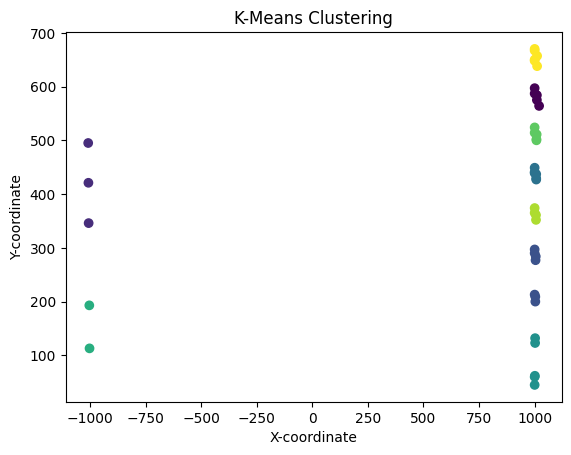

[[-1000   670]
 [-1000   524]
 [-1000   587]
 [-1000   597]
 [-1000   439]
 [-1000   290]
 [-1000   650]
 [-1000   365]
 [-1000   441]
 [-1000   449]
 [-1000   648]
 [-1000   667]
 [-1000   514]
 [-1000    60]
 [-1000   374]
 [-1000   297]
 [-1000   213]
 [ -991   472]
 [ -994   319]
 [ -993   396]
 [ -992   462]
 [ -992   464]
 [ -994   312]
 [ -988   673]
 [ -990   537]
 [ -989   610]
 [ -990   535]
 [ -998    80]
 [ -995   244]
 [ -997   158]
 [ -998    97]
 [ -997   167]
 [ -989   619]
 [ -988   692]
 [ -996   235]
 [ -990   546]
 [ -993   387]
 [ -978   634]
 [  992   456]
 [  993   381]
 [  997   148]
 [  990   530]
 [  996   228]]


In [222]:
_get_vertical_averages(lines)

Detect chesboard corners

In [180]:
def line_intersection(lines):

    points =[]
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):

            line1 = lines[i]
            line2 = lines[j]
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

            def det(a, b):
                return a[0] * b[1] - a[1] * b[0]

            div = det(xdiff, ydiff)
            if div != 0:
                

                d = (det(*line1), det(*line2))
                x = det(d, xdiff) / div
                y = det(d, ydiff) / div
                points.append((x,y)) 
    return points

intersections = line_intersection(lines)

#debug.points(image,inter,color = (0,255,0),size = 10)
inters = np.array(intersections)
inters = inters[np.all((-100 <= inters) & (inters <= 800), axis=1)] # Delete point outside -100 and 800
sorted_intersections = inters[inters[:, 0].argsort()]

sorted_intersections

C:\Users\AMD R3\AppData\Local\Temp\ipykernel_10192\3753785399.py:13: RuntimeWarning: overflow encountered in scalar multiply
  return a[0] * b[1] - a[1] * b[0]
C:\Users\AMD R3\AppData\Local\Temp\ipykernel_10192\3753785399.py:13: RuntimeWarning: overflow encountered in scalar subtract
  return a[0] * b[1] - a[1] * b[0]


array([[ 53.7495246 , 500.52713833],
       [ 53.80096175, 497.59081224],
       [ 53.92469824, 490.52722596],
       ...,
       [700.91176471, 269.85088132],
       [701.94117647, 194.85139629],
       [714.42857143, 344.10505253]])

Trim image

In [181]:
vertex = np.array(sorted_intersections, np.int32)
black_mask = np.zeros_like(image)
cv2.fillPoly(black_mask, [vertex], (255, 255, 255))
trimmed_image = cv2.bitwise_and(image, black_mask)

Detect inner corners

In [182]:
gray_trimmed_image = cv2.cvtColor(trimmed_image, cv2.COLOR_BGR2GRAY)
max_corners = 80
corners = cv2.goodFeaturesToTrack(gray_trimmed_image, max_corners, qualityLevel= 0.1, minDistance= 15)
corners = np.intp(corners)
actual_size = corners.shape[0], corners.shape[2]
corners = corners.reshape(actual_size)

debug.points(trimmed_image,corners, color=(0,255,0), size= 5);

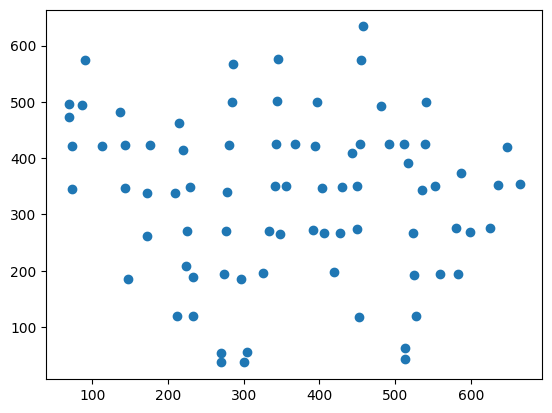

In [183]:
plt.scatter(corners[:,0], corners[:,1])

In [184]:
cv2.imshow('Imagen Original', image)
cv2.imshow('canny', canny)
#cv2.imshow('Imagen Recortada', trimmed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()